<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Lstm_Predictive_maintance_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()


,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [4]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [5]:
df["rul"]=[254-i for i in df.index]

In [6]:
train_df=df[df["Time"]<="2020-01-27 14:00:00"]
test_df = df[df["Time"]>"2020-01-27 14:00:00"]
test_df["rul"]=[i-254 for i in df[df["Time"]>"2020-01-27 14:00:00"].index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
w0=36
w1=12
train_df["label1"]=np.where(train_df["rul"]< w0,1,0)
test_df["label1"]=np.where(test_df["rul"]< 0,1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
train_df["label2"]=np.where(train_df["rul"]<w1,2,0)
test_df["label2"]=np.where(test_df["rul"]<0,1,0)

NameError: ignored

In [21]:
# MinMax normalization (from 0 to 1)

cols_normalize = train_df.columns.difference(['Time','rul',"label2","label1"])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#Test


norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [22]:
train_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,label1,label2
0,2020-01-17 00:00:00,0.490650,0.288555,0.726390,0.319932,0.056941,0.368189,254,0,0
1,2020-01-17 01:00:00,0.474892,0.315152,0.719302,0.322696,0.062360,0.367814,253,0,0
2,2020-01-17 02:00:00,0.469133,0.285393,0.711508,0.317686,0.056204,0.367780,252,0,0
3,2020-01-17 03:00:00,0.483095,0.284592,0.732471,0.319974,0.059123,0.367950,251,0,0
4,2020-01-17 04:00:00,0.408137,0.251231,0.757928,0.276698,0.103320,0.312238,250,0,0
...,...,...,...,...,...,...,...,...,...,...
250,2020-01-27 10:00:00,0.875471,0.270724,0.741377,0.547470,0.004384,0.674694,4,1,2
251,2020-01-27 11:00:00,0.870527,0.274397,0.792968,0.546568,0.010606,0.673571,3,1,2
252,2020-01-27 12:00:00,0.722010,0.194265,0.805558,0.430034,0.119764,0.523467,2,1,2
253,2020-01-27 13:00:00,0.943146,0.276498,0.710346,0.536404,0.004930,0.673435,1,1,2


In [23]:
test_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,rul,label1,label2
0,2020-01-27 15:00:00,0.920649,0.262588,0.712779,0.543988,0.003903,0.674218,1,0,0
1,2020-01-27 16:00:00,0.916203,0.291659,0.714689,0.546046,0.004043,0.674388,2,0,0
2,2020-01-27 17:00:00,0.929025,0.285568,0.710455,0.551171,0.005625,0.675785,3,0,0
3,2020-01-27 18:00:00,0.915819,0.285907,0.720390,0.558555,0.004397,0.682674,4,0,0
4,2020-01-27 19:00:00,0.918672,0.284766,0.691048,0.547760,0.007168,0.672549,5,0,0
...,...,...,...,...,...,...,...,...,...,...
140,2020-02-02 14:00:00,0.015218,0.007606,0.123121,0.069484,0.660379,0.000722,141,0,0
141,2020-02-02 15:00:00,0.032712,0.013931,0.114297,0.085930,0.658951,0.010860,142,0,0
142,2020-02-02 16:00:00,0.972221,0.350657,0.312397,0.752390,0.170908,0.660452,143,0,0
143,2020-02-02 17:00:00,0.784908,0.278872,0.581250,0.495293,0.035764,0.571482,144,0,0


In [24]:
# pick  window size 
sequence_length = 10

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols=train_df.columns[1:7]

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array.shape)


(245, 10, 6)


In [25]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df, sequence_length, ['label1'])]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(245, 1)


In [28]:
model_path = 'classification_model.h5'

In [29]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=200, batch_size=3, validation_split=False, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='loss', save_best_only=True, mode='min', verbose=1)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 100)           42800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
82/82 - 4s - loss: 0.3885 - accuracy: 0.8735

Epoch 00001: loss improved from inf to 0.38845, savin

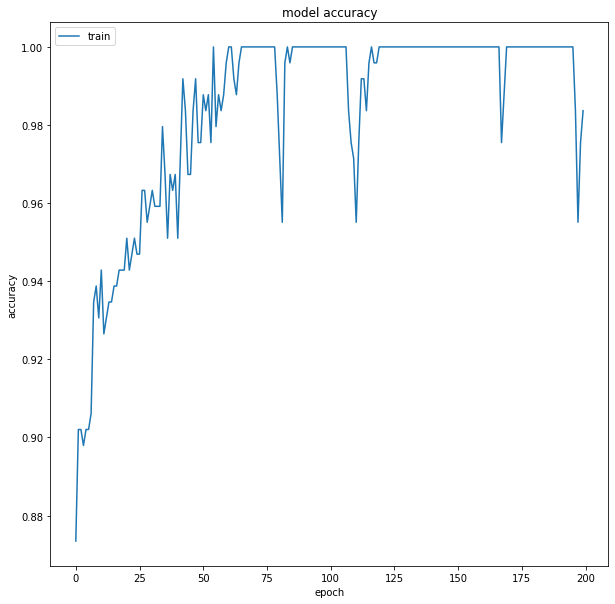

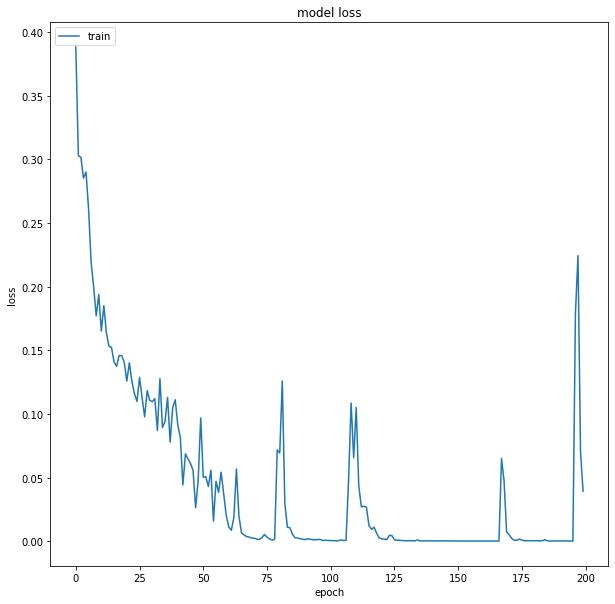

2/2 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9959
Accurracy: 0.9959183931350708


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 12ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[209   0]
 [  1  35]]
Precision: [0.9952381 1.       ]
recall =  [1.         0.97222222]


In [31]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
print("Precision:",precision_score(y_true, y_pred, average=None)) 
recall = recall_score(y_true, y_pred, average=None)
print(  'recall = ', recall)

In [32]:
# pick the feature columns 
sequence_cols=test_df.columns[1:7]

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (135,10,6))
print(seq_array_test_last.shape)

(135, 10, 6)


In [33]:
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['label1'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)

(135, 1)


5/5 - 1s - loss: 0.5738 - accuracy: 0.9111
Accurracy: 0.9111111164093018


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[123  12]
 [  0   0]]
Precision:  0.0 
 Recall:  0.0 
 F1-score: nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


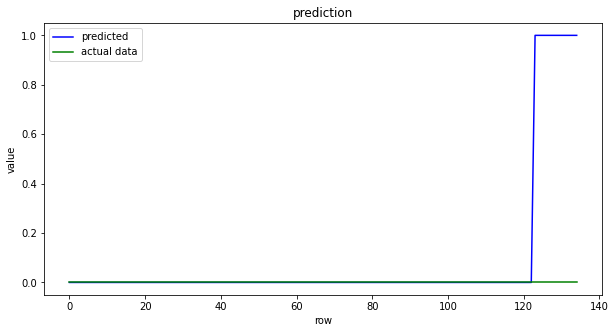

In [34]:

import os
os.chdir("/content")
estimator = load_model("/content")
# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")